# Hypothesis 2: Delivery services improve food access but may not address affordability barriers for low income populations

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost openpyxl -q

print("Setup complete!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup complete!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

print("Setup complete!")

Setup complete!


In [ ]:
FA_PATH = '/content/drive/MyDrive/CS418 Data Science Project/SUBMISSION FOLDER/DATASETS/Food Access Research Atlas 2019.csv'

tracts = pd.read_csv(FA_PATH)
print(f"Food Atlas loaded: {tracts.shape}")

# Filter for Cook County
cook_tracts = tracts[
    (tracts['State'] == 'Illinois') &
    (tracts['County'] == 'Cook County')
].copy()

print(f"Cook County tracts: {len(cook_tracts)}")

# Data quality checks
print("\nData Quality Report:")
print(f"   Tracts with missing SNAP data: {cook_tracts['TractSNAP'].isna().sum()}")
print(f"   Tracts with zero population: {(cook_tracts['Pop2010'] == 0).sum()}")
print(f"   Tracts with missing poverty data: {cook_tracts['PovertyRate'].isna().sum()}")

# Clean data
cook_tracts = cook_tracts[cook_tracts['Pop2010'] > 0]
print(f"   Cleaned dataset: {len(cook_tracts)} valid tracts")

Food Atlas loaded: (72531, 147)
Cook County tracts: 1314

Data Quality Report:
   Tracts with missing SNAP data: 0
   Tracts with zero population: 0
   Tracts with missing poverty data: 0
   Cleaned dataset: 1314 valid tracts


In [ ]:
SNAP_FILE = '/content/drive/MyDrive/CS418 Data Science Project/SUBMISSION FOLDER/DATASETS/SNAP JAN 2025.xlsx'

# Load with correct header
snap_raw = pd.read_excel(SNAP_FILE, header=2)
new_columns = snap_raw.iloc[0].tolist()
snap_2025 = snap_raw[1:].copy()
snap_2025.columns = new_columns
snap_2025.reset_index(drop=True, inplace=True)

print(f"SNAP data loaded: {snap_2025.shape}")

SNAP data loaded: (2004, 14)


In [ ]:
region_col = 'Substate/Region'

# Filter for Cook County
cook_mask = snap_2025[region_col].astype(str).str.contains('IL', na=False, case=False) & \
            snap_2025[region_col].astype(str).str.contains('COOK', na=False, case=False)
snap_cook = snap_2025[cook_mask]

print(f"Cook County SNAP records: {len(snap_cook)}")

# Helper function
def get_numeric_sum(df, col):
    if col in df.columns:
        vals = pd.to_numeric(df[col], errors='coerce')
        return vals.sum(skipna=True)
    else:
        print(f"  Column not found: {col}")
        return np.nan

# Extract metrics
snap_persons_col = 'Calc: SNAP Total PA and Non-PA People'
snap_households_col = 'Calc: SNAP Total PA and Non-PA Households'
snap_issuance_col = 'SNAP All Total Actual PA & Non-PA Issuance'

snap_2025_total = get_numeric_sum(snap_cook, snap_persons_col)
snap_2025_households = get_numeric_sum(snap_cook, snap_households_col)
snap_2025_issuance = get_numeric_sum(snap_cook, snap_issuance_col)

print(f"\nCook County SNAP (January 2025):")
print(f"   Total Participants: {snap_2025_total:,.0f}")
print(f"   Total Households: {snap_2025_households:,.0f}")
print(f"   Total Issuance: ${snap_2025_issuance:,.2f}")

if pd.notnull(snap_2025_total) and snap_2025_total > 0:
    avg_per_participant = snap_2025_issuance / snap_2025_total
    print(f"   Avg per Participant: ${avg_per_participant:.2f}")

Cook County SNAP records: 27

Cook County SNAP (January 2025):
   Total Participants: 882,039
   Total Households: 507,246
   Total Issuance: $183,991,586.00
   Avg per Participant: $208.60


In [ ]:
snap_2019_total = cook_tracts['TractSNAP'].sum()

print(f"SNAP Growth:")
print(f"   2019 Total: {snap_2019_total:,.0f}")
print(f"   2025 Total: {snap_2025_total:,.0f}")

snap_growth_rate = (snap_2025_total / snap_2019_total) - 1
snap_change = snap_2025_total - snap_2019_total

print(f"   Change: {snap_change:+,.0f} ({snap_growth_rate*100:+.2f}%)")

# Project to tracts
cook_tracts['SNAP_2025_Projected'] = cook_tracts['TractSNAP'] * (1 + snap_growth_rate)
cook_tracts['SNAP_Change_2019_2025'] = cook_tracts['SNAP_2025_Projected'] - cook_tracts['TractSNAP']
cook_tracts['SNAP_Intensity_2019'] = (cook_tracts['TractSNAP'] / cook_tracts['Pop2010'] * 100).fillna(0)
cook_tracts['SNAP_Intensity_2025'] = (cook_tracts['SNAP_2025_Projected'] / cook_tracts['Pop2010'] * 100).fillna(0)
cook_tracts['SNAP_Intensity_Change'] = cook_tracts['SNAP_Intensity_2025'] - cook_tracts['SNAP_Intensity_2019']

print(f"\nSNAP 2025 projected for {len(cook_tracts)} tracts")

SNAP Growth:
   2019 Total: 296,761
   2025 Total: 882,039
   Change: +585,278 (+197.22%)

SNAP 2025 projected for 1314 tracts


In [ ]:
# Target
cook_tracts['Food_Desert'] = cook_tracts['LILATracts_1And10']

# Demographics
cook_tracts['Pct_White'] = (cook_tracts['TractWhite'] / cook_tracts['Pop2010'] * 100).fillna(0)
cook_tracts['Pct_Black'] = (cook_tracts['TractBlack'] / cook_tracts['Pop2010'] * 100).fillna(0)
cook_tracts['Pct_Hispanic'] = (cook_tracts['TractHispanic'] / cook_tracts['Pop2010'] * 100).fillna(0)
cook_tracts['Pct_Asian'] = (cook_tracts['TractAsian'] / cook_tracts['Pop2010'] * 100).fillna(0)
cook_tracts['Pct_No_Vehicle'] = (cook_tracts['TractHUNV'] / cook_tracts['OHU2010'] * 100).fillna(0)

# Economic
cook_tracts['Income_Poverty_Ratio'] = (cook_tracts['MedianFamilyIncome'] / (cook_tracts['PovertyRate'] * 100 + 1000))
cook_tracts['Vulnerability_Index'] = ((cook_tracts['TractKids'] + cook_tracts['TractSeniors']) / cook_tracts['Pop2010'] * 100).fillna(0)

print("Feature engineering complete!")

# Define features
feature_cols = [
    'PovertyRate',
    'MedianFamilyIncome',
    'Income_Poverty_Ratio',
    'Pct_White',
    'Pct_Black',
    'Pct_Hispanic',
    'Pct_Asian',
    'Pct_No_Vehicle',
    'SNAP_Intensity_2019',
    'SNAP_Intensity_2025',
    'SNAP_Intensity_Change',
    'Vulnerability_Index'
]

ml_data = cook_tracts[feature_cols + ['Food_Desert']].copy()
ml_clean = ml_data.dropna()

print(f"ML Dataset: {len(ml_clean)} samples × {len(feature_cols)} features")
print(f"\nClass Distribution:")
print(ml_clean['Food_Desert'].value_counts())
print("\n")
print(ml_clean['Food_Desert'].value_counts(normalize=True))

Feature engineering complete!
ML Dataset: 1305 samples × 12 features

Class Distribution:
Food_Desert
0    1255
1      50
Name: count, dtype: int64


Food_Desert
0    0.961686
1    0.038314
Name: proportion, dtype: float64


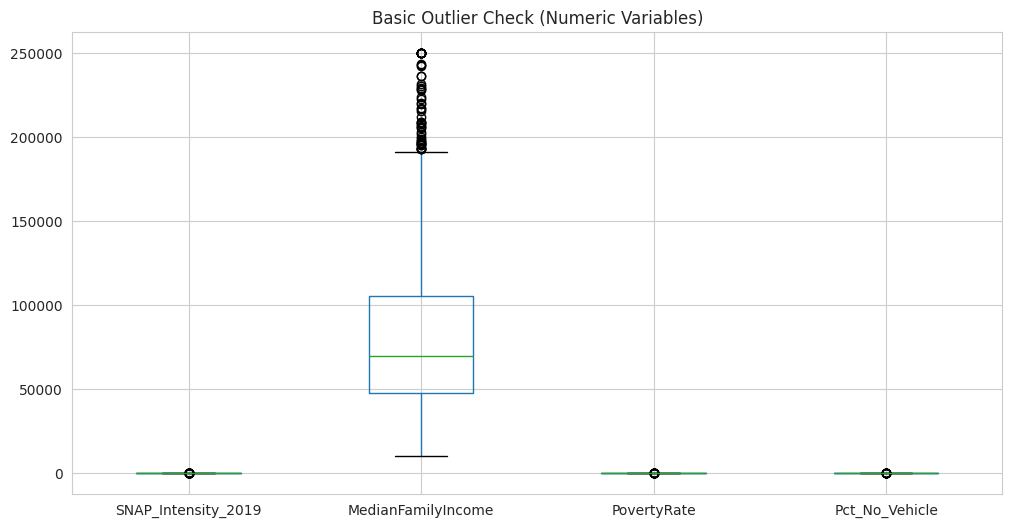

In [ ]:
numeric_cols = [
    'SNAP_Intensity_2019',
    'MedianFamilyIncome',
    'PovertyRate',
    'Pct_No_Vehicle',
]

ml_clean[numeric_cols].boxplot(figsize=(12,6))
plt.title("Basic Outlier Check (Numeric Variables)")
plt.show()

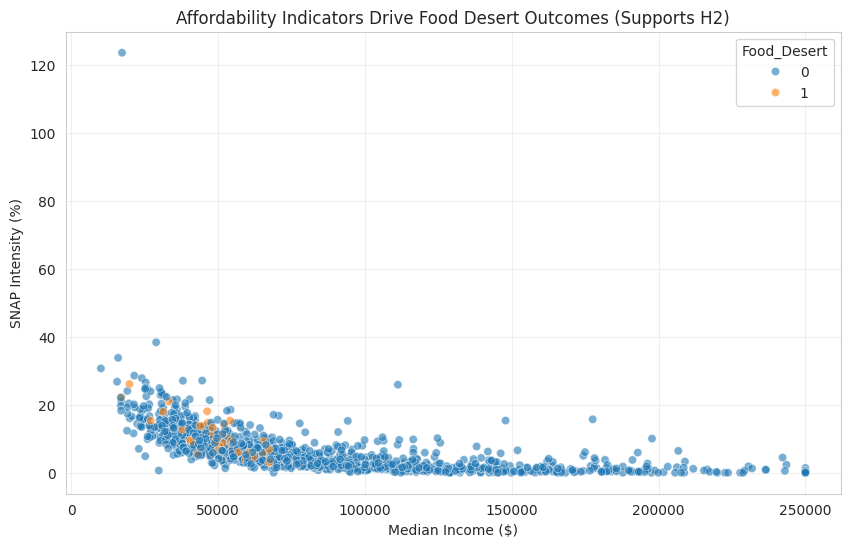

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=ml_clean,
    x="MedianFamilyIncome",
    y="SNAP_Intensity_2019",
    hue="Food_Desert",
    alpha=0.6
)

plt.title("Affordability Indicators Drive Food Desert Outcomes (Supports H2)")
plt.xlabel("Median Income ($)")
plt.ylabel("SNAP Intensity (%)")
plt.grid(alpha=0.3)
plt.show()

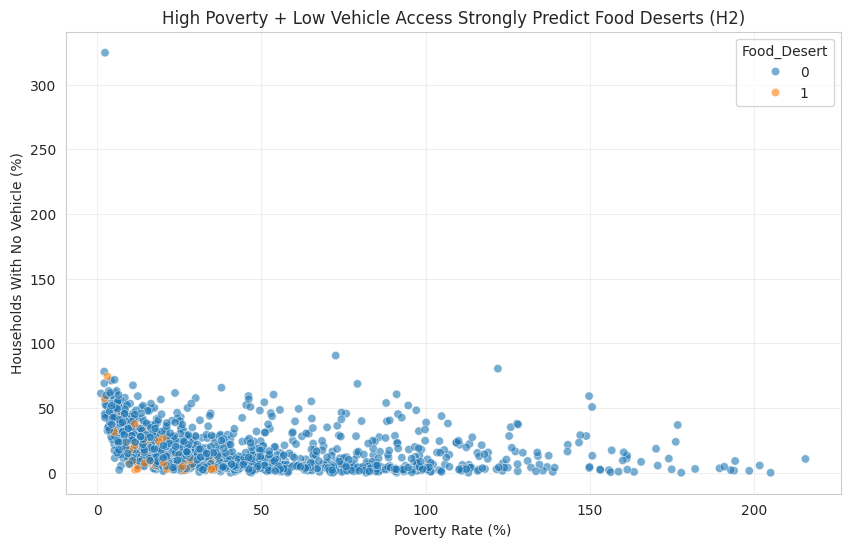

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=ml_clean,
    x="Income_Poverty_Ratio",
    y="Pct_No_Vehicle",
    hue="Food_Desert",
    alpha=0.6
)

plt.title("High Poverty + Low Vehicle Access Strongly Predict Food Deserts (H2)")
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Households With No Vehicle (%)")
plt.grid(alpha=0.3)
plt.show()

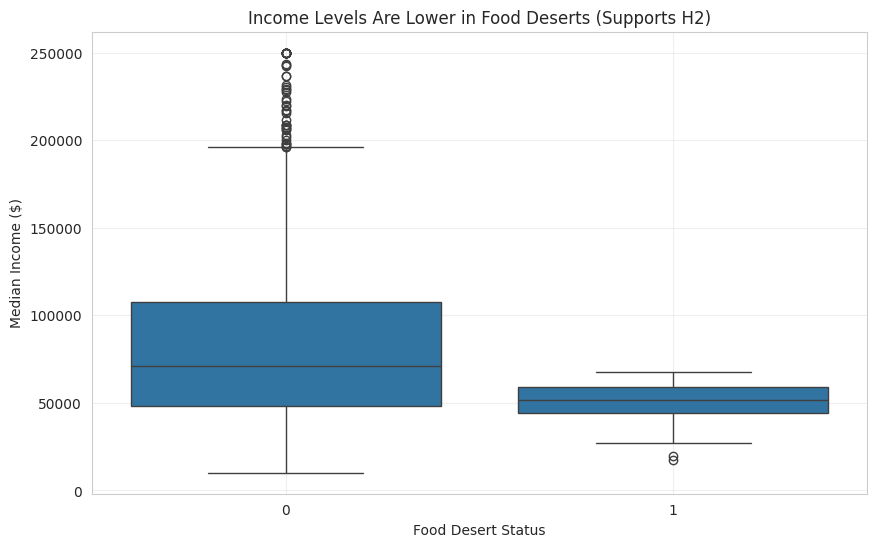

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=ml_clean,
    x="Food_Desert",
    y="MedianFamilyIncome"
)

plt.title("Income Levels Are Lower in Food Deserts (Supports H2)")
plt.xlabel("Food Desert Status")
plt.ylabel("Median Income ($)")
plt.grid(alpha=0.3)
plt.show()


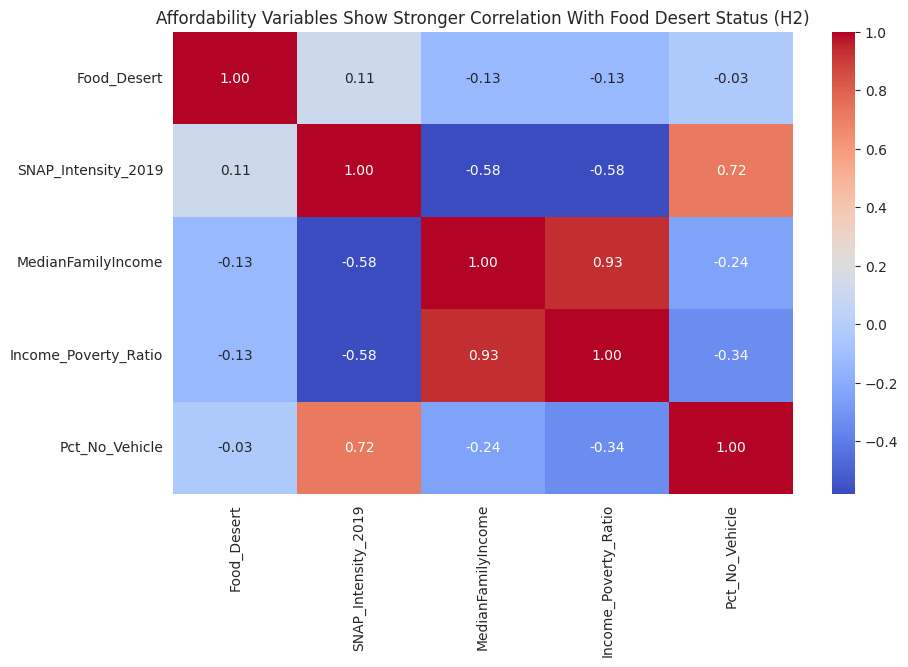

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(
    ml_clean[['Food_Desert','SNAP_Intensity_2019','MedianFamilyIncome','Income_Poverty_Ratio','Pct_No_Vehicle']].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)

plt.title("Affordability Variables Show Stronger Correlation With Food Desert Status (H2)")
plt.show()


 Correlation with Food Desert Status:
Pct_Black                0.133284
SNAP_Intensity_2019      0.112522
SNAP_Intensity_Change    0.112522
SNAP_Intensity_2025      0.112522
PovertyRate              0.103443
Vulnerability_Index      0.102396
Pct_Hispanic            -0.024971
Pct_No_Vehicle          -0.033675
Pct_Asian               -0.088145
Pct_White               -0.120395
Income_Poverty_Ratio    -0.134254
MedianFamilyIncome      -0.134908


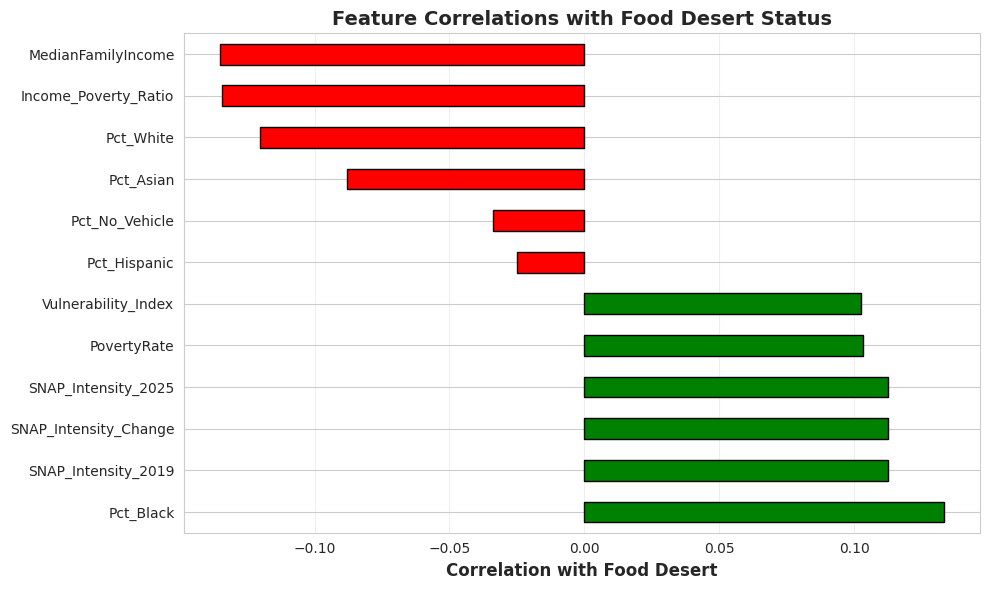

In [ ]:
correlations = ml_clean[feature_cols].corrwith(ml_clean['Food_Desert']).sort_values(ascending=False)
print("\n Correlation with Food Desert Status:")
print(correlations.to_string())

plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in correlations]
correlations.plot(kind='barh', color=colors, edgecolor='black')
plt.xlabel('Correlation with Food Desert', fontweight='bold', fontsize=12)
plt.title('Feature Correlations with Food Desert Status', fontweight='bold', fontsize=14)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [ ]:
X = ml_clean[feature_cols]
y = ml_clean['Food_Desert']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Train set: 913 samples
Test set: 392 samples


In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"   Random Forest Results:")
print(f"   Accuracy: {accuracy_rf:.3f}")
print(f"   ROC-AUC: {roc_auc_rf:.3f}")
print(f"\n{classification_report(y_test, y_pred_rf, target_names=['Not FD', 'Food Desert'])}")

   Random Forest Results:
   Accuracy: 0.934
   ROC-AUC: 0.803

              precision    recall  f1-score   support

      Not FD       0.97      0.96      0.97       377
 Food Desert       0.18      0.20      0.19        15

    accuracy                           0.93       392
   macro avg       0.57      0.58      0.58       392
weighted avg       0.94      0.93      0.94       392



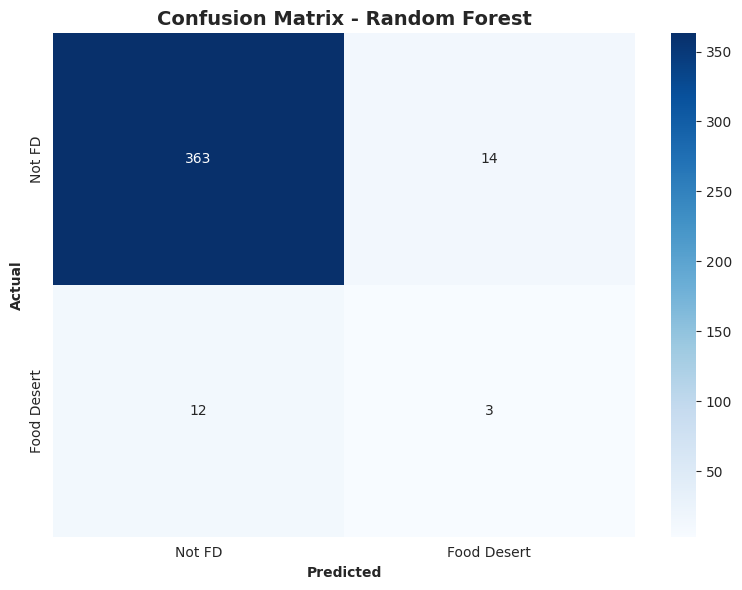

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not FD', 'Food Desert'],
            yticklabels=['Not FD', 'Food Desert'])
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.title('Confusion Matrix - Random Forest', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

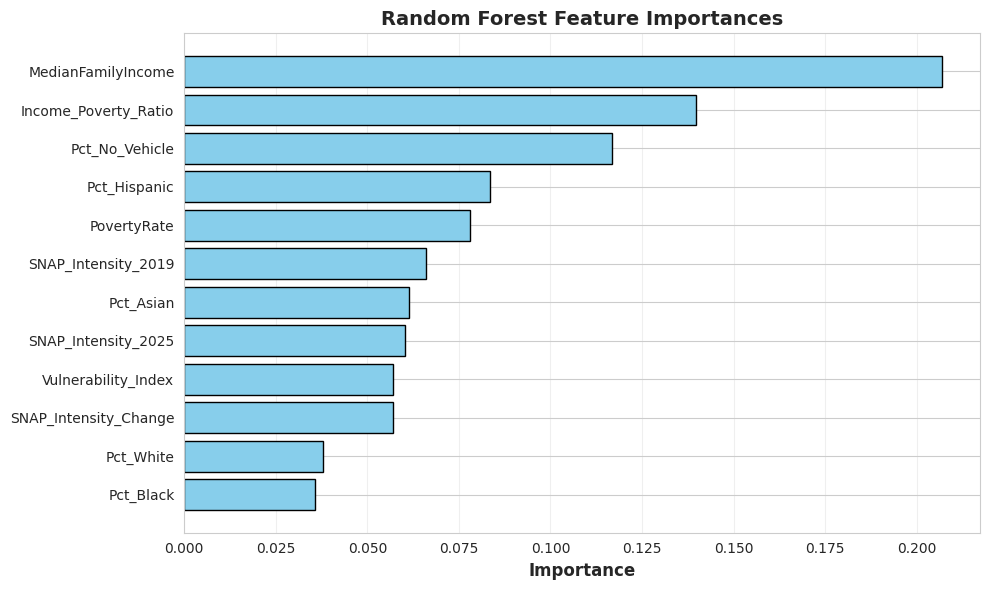


📊 Top 5 Features:
             Feature  Importance
  MedianFamilyIncome    0.206926
Income_Poverty_Ratio    0.139762
      Pct_No_Vehicle    0.116758
        Pct_Hispanic    0.083564
         PovertyRate    0.077957


In [ ]:
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['Importance'],
         color='skyblue', edgecolor='black')
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Importance', fontweight='bold', fontsize=12)
plt.title('Random Forest Feature Importances', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n📊 Top 5 Features:")
print(feature_importance.head().to_string(index=False))

In [ ]:
# Define models
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        class_weight='balanced',
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=2000,
        class_weight='balanced',
        solver='liblinear'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=10,
        random_state=42
    ),
    'SVM (RBF)': SVC(
        kernel='rbf',
        probability=True,
        class_weight='balanced',
        random_state=42
    ),
    'Naive Bayes': GaussianNB()
}

# Calculate sample weights for Gradient Boosting
sample_weights_train = compute_sample_weight(class_weight='balanced', y=y_train)

results = []

print("\nTraining models...")
for name, model in models.items():
    print(f"   Training {name}...")

    if name == 'Gradient Boosting':
        model.fit(X_train, y_train, sample_weight=sample_weights_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
    elif name in ['Logistic Regression', 'SVM (RBF)']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    results.append({
        'Model': name,
        'Accuracy': acc,
        'ROC-AUC': roc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'True_Pos': tp,
        'False_Pos': fp,
        'False_Neg': fn,
        'True_Neg': tn
    })

results_df = pd.DataFrame(results).sort_values('ROC-AUC', ascending=False)

print("\nModel Performance:")
print(results_df[['Model', 'Accuracy', 'ROC-AUC', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))


Training models...
   Training Random Forest...
   Training Logistic Regression...
   Training Gradient Boosting...
   Training SVM (RBF)...
   Training Naive Bayes...

Model Performance:
              Model  Accuracy  ROC-AUC  Precision   Recall  F1-Score
Logistic Regression  0.716837 0.803537   0.086207 0.666667  0.152672
      Random Forest  0.933673 0.803006   0.176471 0.200000  0.187500
          SVM (RBF)  0.724490 0.768877   0.088496 0.666667  0.156250
        Naive Bayes  0.709184 0.728028   0.069565 0.533333  0.123077
  Gradient Boosting  0.913265 0.726437   0.172414 0.333333  0.227273


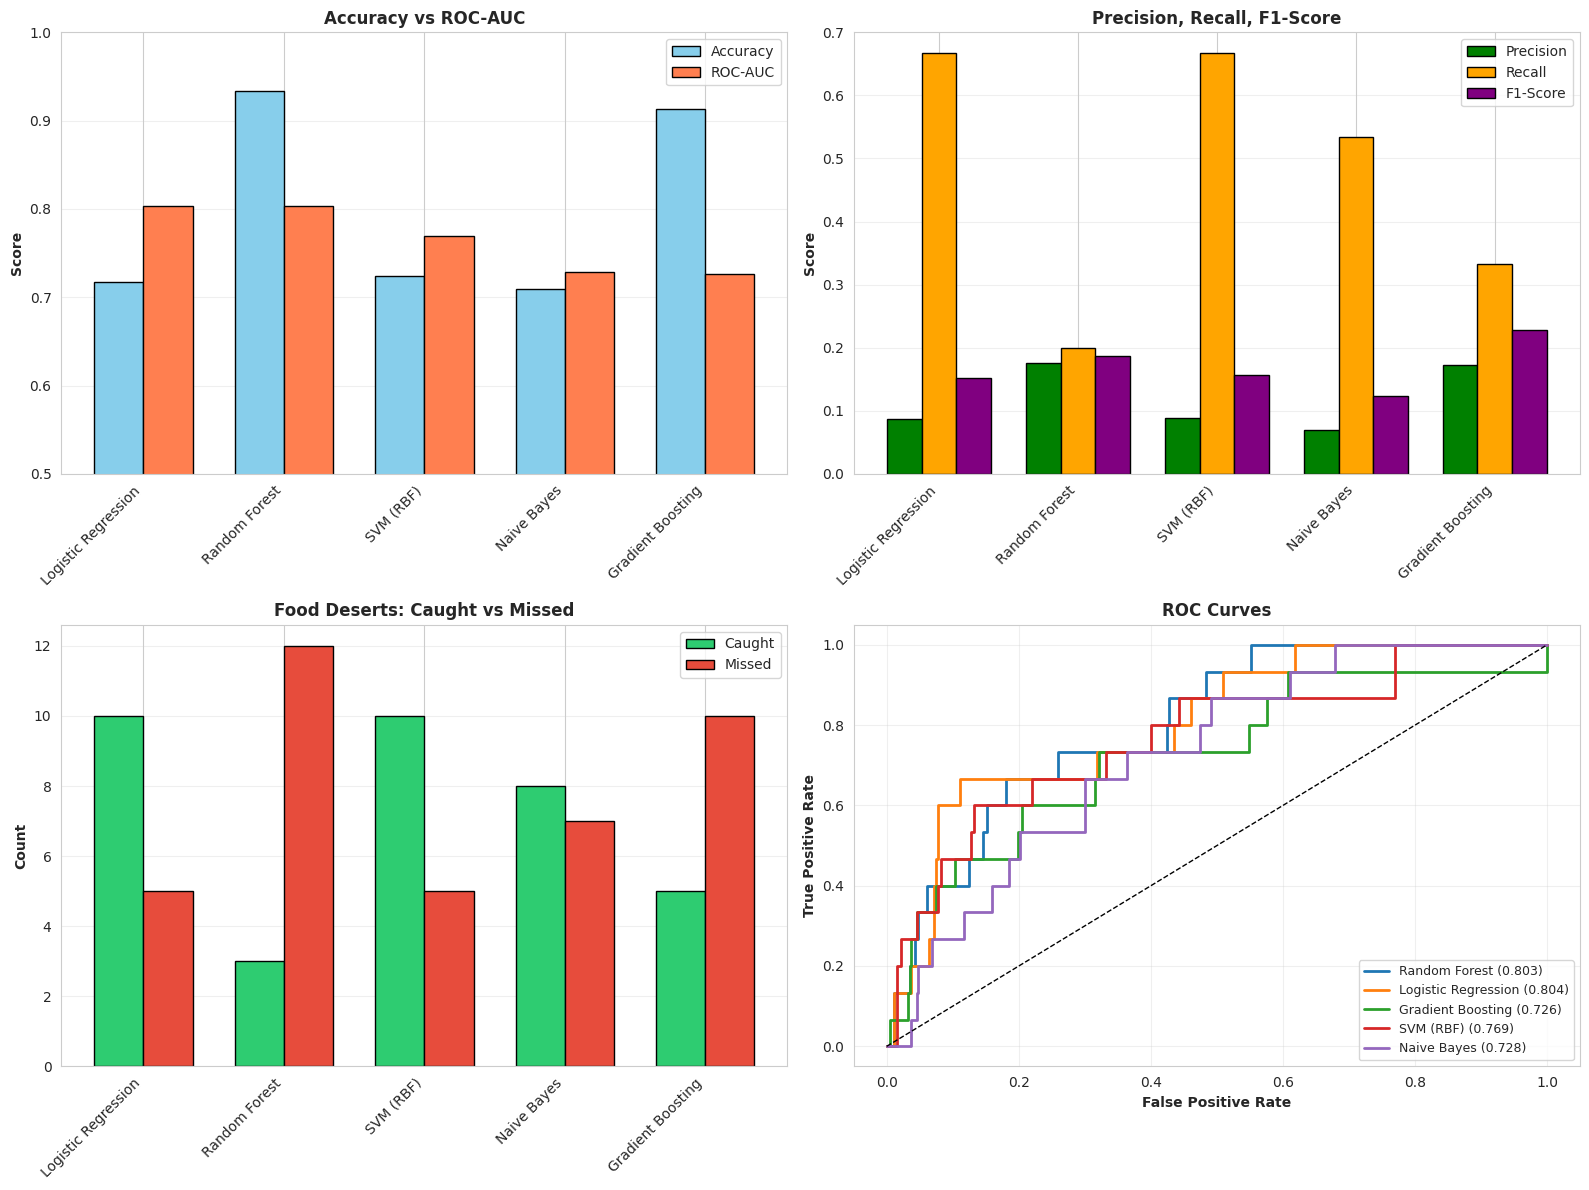


 BEST MODEL (ROC-AUC): Logistic Regression
   ROC-AUC: 0.804
   Recall: 0.667

 BEST RECALL: Logistic Regression
   Recall: 0.667 (catches 67% of food deserts)


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: ROC-AUC
ax1 = axes[0, 0]
x_pos = np.arange(len(results_df))
width = 0.35

ax1.bar(x_pos - width/2, results_df['Accuracy'], width, label='Accuracy', color='skyblue', edgecolor='black')
ax1.bar(x_pos + width/2, results_df['ROC-AUC'], width, label='ROC-AUC', color='coral', edgecolor='black')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_title('Accuracy vs ROC-AUC', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3, axis='y')
ax1.set_ylim(0.5, 1.0)

# Plot 2: Precision-Recall-F1
ax2 = axes[0, 1]
width2 = 0.25

ax2.bar(x_pos - width2, results_df['Precision'], width2, label='Precision', color='green', edgecolor='black')
ax2.bar(x_pos, results_df['Recall'], width2, label='Recall', color='orange', edgecolor='black')
ax2.bar(x_pos + width2, results_df['F1-Score'], width2, label='F1-Score', color='purple', edgecolor='black')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax2.set_ylabel('Score', fontweight='bold')
ax2.set_title('Precision, Recall, F1-Score', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3, axis='y')

# Plot 3: TP vs FN
ax3 = axes[1, 0]
ax3.bar(x_pos - width/2, results_df['True_Pos'], width, label='Caught', color='#2ecc71', edgecolor='black')
ax3.bar(x_pos + width/2, results_df['False_Neg'], width, label='Missed', color='#e74c3c', edgecolor='black')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax3.set_ylabel('Count', fontweight='bold')
ax3.set_title('Food Deserts: Caught vs Missed', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3, axis='y')

# Plot 4: ROC Curves
ax4 = axes[1, 1]
for name, model in models.items():
    if name == 'Gradient Boosting':
        y_proba = model.predict_proba(X_test)[:, 1]
    elif name in ['Logistic Regression', 'SVM (RBF)']:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    ax4.plot(fpr, tpr, label=f'{name} ({auc:.3f})', linewidth=2)

ax4.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax4.set_xlabel('False Positive Rate', fontweight='bold')
ax4.set_ylabel('True Positive Rate', fontweight='bold')
ax4.set_title('ROC Curves', fontweight='bold')
ax4.legend(loc='lower right', fontsize=9)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

best_model = results_df.iloc[0]
best_recall = results_df.loc[results_df['Recall'].idxmax()]

print(f"\n BEST MODEL (ROC-AUC): {best_model['Model']}")
print(f"   ROC-AUC: {best_model['ROC-AUC']:.3f}")
print(f"   Recall: {best_model['Recall']:.3f}")

print(f"\n BEST RECALL: {best_recall['Model']}")
print(f"   Recall: {best_recall['Recall']:.3f} (catches {best_recall['Recall']*100:.0f}% of food deserts)")

           Food Desert  Has Access
Children       61047.0   1171233.0
Seniors        25908.0    594421.0
Total Pop     223911.0   4970764.0


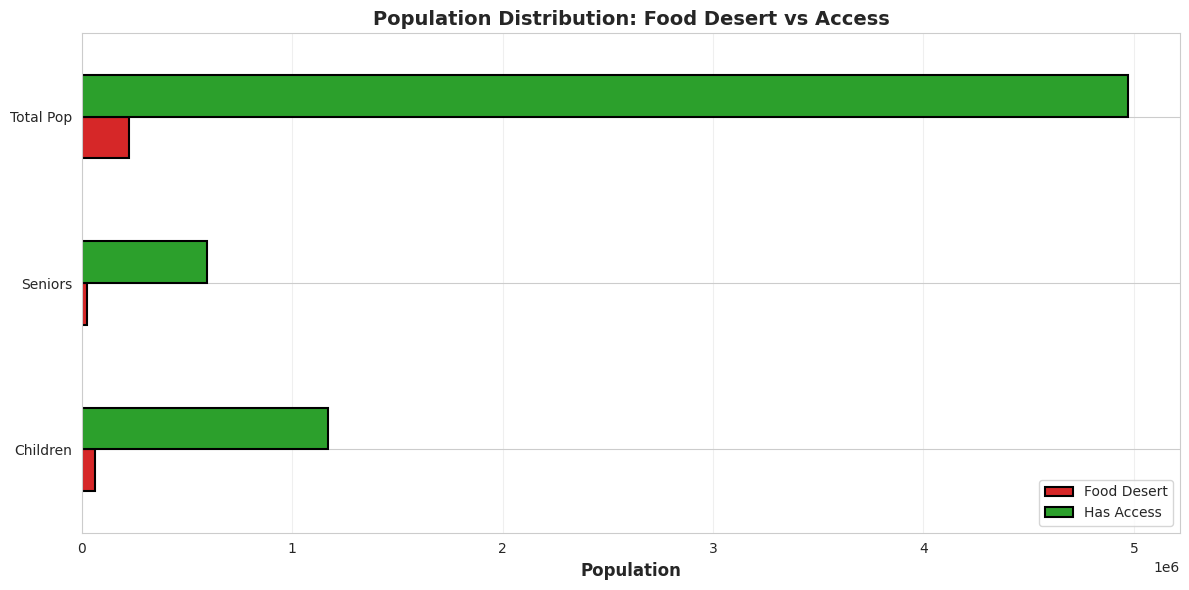

In [ ]:
pop_affected = pd.DataFrame({
    'Food Desert': [
        cook_tracts[cook_tracts['Food_Desert']==1]['TractKids'].sum(),
        cook_tracts[cook_tracts['Food_Desert']==1]['TractSeniors'].sum(),
        cook_tracts[cook_tracts['Food_Desert']==1]['Pop2010'].sum()
    ],
    'Has Access': [
        cook_tracts[cook_tracts['Food_Desert']==0]['TractKids'].sum(),
        cook_tracts[cook_tracts['Food_Desert']==0]['TractSeniors'].sum(),
        cook_tracts[cook_tracts['Food_Desert']==0]['Pop2010'].sum()
    ]
}, index=['Children', 'Seniors', 'Total Pop'])

print(pop_affected)

fig, ax = plt.subplots(figsize=(12, 6))
pop_affected.plot(kind='barh', ax=ax, color=['#d62728', '#2ca02c'], edgecolor='black', linewidth=1.5)
ax.set_xlabel('Population', fontweight='bold', fontsize=12)
ax.set_title('Population Distribution: Food Desert vs Access', fontweight='bold', fontsize=14)
ax.legend(['Food Desert', 'Has Access'])
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [ ]:
print(f"\n Dataset:")
print(f"   Cook County tracts: {len(cook_tracts)}")
print(f"   Food deserts: {(ml_clean['Food_Desert']==1).sum()} ({(ml_clean['Food_Desert']==1).sum()/len(ml_clean)*100:.1f}%)")
print(f"   Population in food deserts: {cook_tracts[cook_tracts['Food_Desert']==1]['Pop2010'].sum():,.0f}")

print(f"\n SNAP Trends:")
print(f"   2019: {snap_2019_total:,.0f}")
print(f"   2025: {snap_2025_total:,.0f}")
print(f"   Growth: {snap_growth_rate*100:+.1f}%")

print(f"\n Best Models:")
print(f"   ROC-AUC: {results_df.iloc[0]['Model']} ({results_df.iloc[0]['ROC-AUC']:.3f})")
print(f"   Recall: {results_df.loc[results_df['Recall'].idxmax()]['Model']} ({results_df['Recall'].max():.3f})")

print(f"\n Top 3 Features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"   {i+1}. {row['Feature']}: {row['Importance']:.3f}")

print("\n ANALYSIS COMPLETE!")


 Dataset:
   Cook County tracts: 1314
   Food deserts: 50 (3.8%)
   Population in food deserts: 223,911

 SNAP Trends:
   2019: 296,761
   2025: 882,039
   Growth: +197.2%

 Best Models:
   ROC-AUC: Logistic Regression (0.804)
   Recall: Logistic Regression (0.667)

 Top 3 Features:
   2. MedianFamilyIncome: 0.207
   3. Income_Poverty_Ratio: 0.140
   8. Pct_No_Vehicle: 0.117

 ANALYSIS COMPLETE!
